# CASSIOPE Data

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from spacepy import pycdf
from scipy.ndimage import uniform_filter1d

Functions to load noise

In [9]:
cdf = pycdf.CDF(r'utility\SPACE_DATA\cassiope.cdf')
B_in = np.array(cdf['B_inboard_CRF']).T
B_out = np.array(cdf['B_outboard_CRF']).T
t = np.array(cdf['Timestamp'])


In [93]:
B = np.array([B_in[:,:100000], B_out[:,:100000]])
t = t[:100000]
B = B - uniform_filter1d(B, size=3000, axis=-1)
B = B[:,:,73000:97000]
t = t[73000:97000]
noise = B[1] - B[0]

In [97]:
print(t.shape)

(0,)


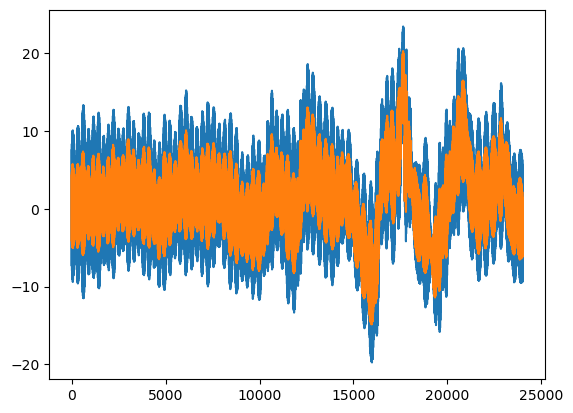

In [98]:
plt.plot(B[0,2])
plt.plot(B[1,2])


Find Coupling Coefficients

In [147]:
from algorithms import RAMEN
from scipy.stats import pearsonr
import importlib

importlib.reload(RAMEN)

axis = 0
RAMEN.fs = 1000/6
RAMEN.weights = np.geomspace(10,.1,B.shape[0])
RAMEN.sspTol = 15
result_ramen = RAMEN.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_ramen, noise[axis])[0])
print(pearsonr(B[1,axis], noise[axis])[0])
print(RAMEN.aii)

-0.07289293403475214
-0.08000329817967126
[[ 1.         1.       ]
 [ 1.        14.9397115]]


c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\RAMEN.py:123: RuntimeWarning: invalid value encountered in divide
  


In [148]:
from algorithms import WAICUPV2
importlib.reload(WAICUPV2)
WAICUPV2.fs = 1000/6
WAICUPV2.uf=10000
WAICUPV2.detrend = True
#WAICUPV2.weights = np.geomspace(1,.1,B.shape[0])
WAICUPV2.gain_method = 'ramen'
WAICUPV2.sspTol = 30
WAICUPV2.flip = True
result_waicup = WAICUPV2.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_waicup, noise[axis])[0])
print(pearsonr(B[1,axis], noise[axis])[0])

c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\WAICUPV2.py:174: RuntimeWarning: invalid value encountered in divide
  
c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\WAICUPV2.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  amb_mf = r_sum * (dj * dt ** .5 / (w[0].C_d * Y_00.real))
c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\WAICUPV2.py:174: RuntimeWarning: Mean of empty slice
  


-0.06065203491789911
-0.08000329817967126


In [149]:
from algorithms import HOG
importlib.reload(HOG)

HOG.fs = 1000/6
HOG.weights = np.geomspace(10,.1,B.shape[0])
HOG.sspTol = 30
HOG.gain_method = 'ramen'

result_hog= HOG.clean(np.flip(np.copy(B[:,axis]), axis=0), triaxial=False)
print(pearsonr(result_hog, noise[axis])[0])
print(pearsonr(B[1,axis], noise[axis])[0])
print(HOG.aii)

c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\HOG.py:140: RuntimeWarning: invalid value encountered in divide
  def filter_wavelets(w, sspTol=15):


-0.07362551156880442
-0.08000329817967126
[[ 1.          1.        ]
 [ 1.         16.53958484]]


In [165]:
from algorithms import REAM
importlib.reload(REAM)

REAM.uf = 10000
REAM.detrend = True
REAM.delta_B = .1

result_ream= REAM.clean(np.flip(np.copy(B[:,axis]), axis=0), triaxial=False)
print(pearsonr(result_ream, noise[axis])[0])
print(pearsonr(B[1,axis], noise[axis])[0])

-0.0006629413821719356
-0.08000329817967126


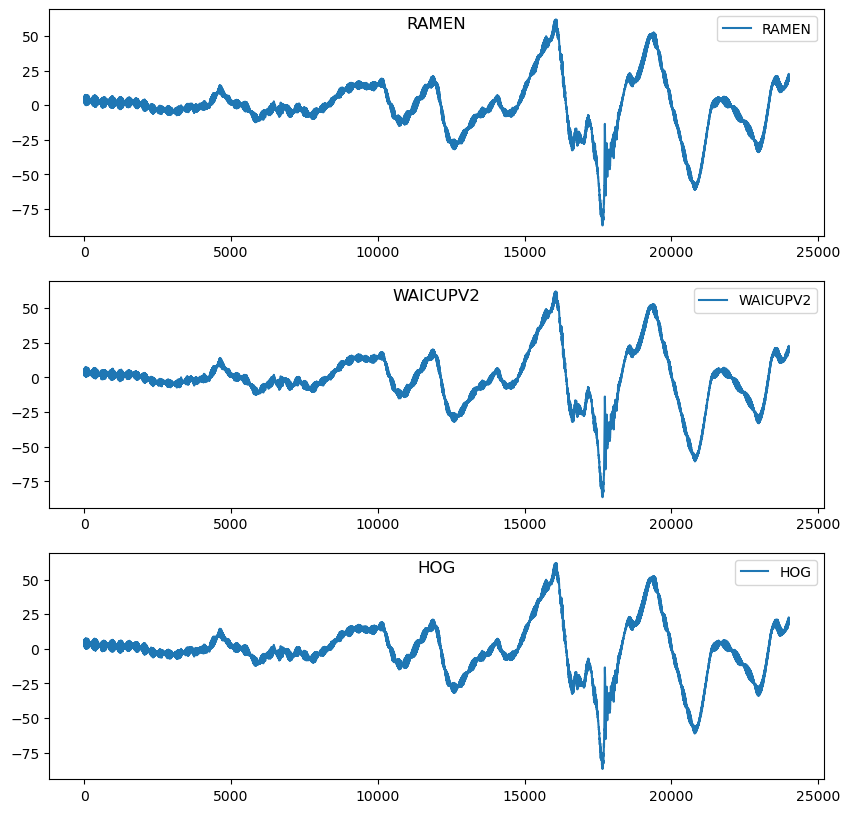

In [166]:
# Make 3,1 subplot and overlay swarm on each result. Set location of each title to within the plot
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(result_ramen, label = 'RAMEN')
axs[0].set_title("RAMEN", y=1.0, pad=-14)
axs[0].legend()
axs[1].plot(result_waicup, label = 'WAICUPV2')
axs[1].set_title('WAICUPV2', y=1.0, pad=-14)
axs[1].legend()
axs[2].plot(result_hog, label = 'HOG')
axs[2].set_title('HOG', y=1.0, pad=-14)
axs[2].legend()


In [167]:
"Take Continuous Wavelet Transform"
import fcwt
fs= int(1000/6)  # Hz
f0 = 0.1  # Hz
f1 = fs/2  # Hz

# take transform of B_kplo Z-axis
freqs_michibiki, out_michibiki= fcwt.cwt(B[1,axis], fs, f0, f1, fn=300, scaling='linear', nthreads=12)
freqs_michibiki = np.flip(freqs_michibiki)

# take transform of WAICUP Z-axis
_, out_ramen = fcwt.cwt(result_ream, fs, f0, f1, fn=300, scaling='linear', nthreads=12)

# take transform of B_kplo Z-axis
_, out_noise = fcwt.cwt(noise[axis], fs, f0, f1, fn=300, scaling='linear', nthreads=12)

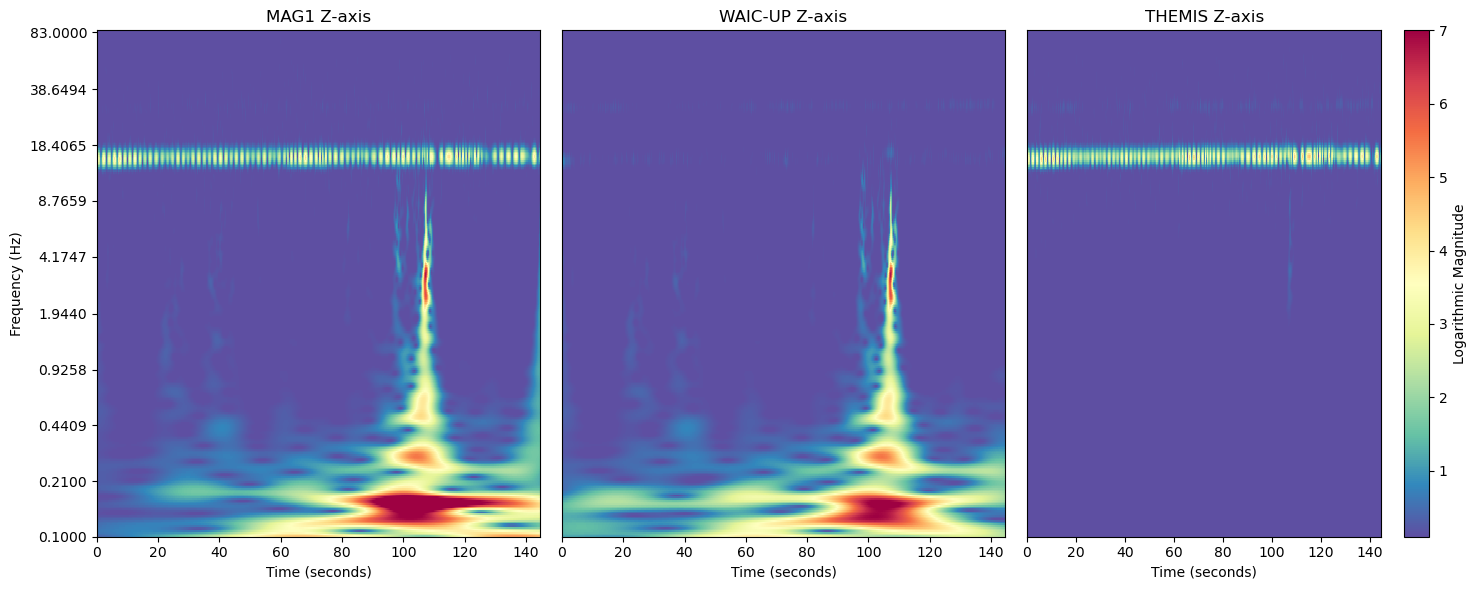

In [168]:

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
extent = [0, out_michibiki.shape[1] / fs, 0, out_michibiki.shape[0]]
cax1 = axs[0].imshow(np.abs(out_michibiki), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=7)
cax2 = axs[1].imshow(np.abs(out_ramen), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=7)
cax3 = axs[2].imshow(np.abs(out_noise), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=7)

#fig.colorbar(cax1, ax=axs[0], label='Logarithmic Magnitude')
#fig.colorbar(cax2, ax=axs[1], label='Logarithmic Magnitude')
fig.colorbar(cax3, ax=axs[2], label='Logarithmic Magnitude')

yticks_kplo = np.linspace(0, len(freqs_michibiki) - 1, 10).astype(int)
yticklabels_kplo = [f"{freqs_michibiki[i]:.4f}" for i in yticks_kplo]

axs[0].set_yticks(yticks_kplo)
axs[0].set_yticklabels(yticklabels_kplo)
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title("MAG1 Z-axis")

# TURN OFF YTICKS FOR AXS[1] AND AXS[2]
axs[1].set_yticks([])
axs[1].set_xlabel('Time (seconds)')
axs[1].set_title("WAIC-UP Z-axis")
axs[2].set_yticks([])
axs[2].set_xlabel('Time (seconds)')
axs[2].set_title("THEMIS Z-axis")


plt.tight_layout()
plt.show()
